In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
plt.rc('font', family='Times New Roman')
import h5py
import seaborn as sns
import os

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline

## Load Tumor and Normal Sample Matrices

In [2]:
tumor_samples = pd.read_csv('../../data/pancancer/TCGA/methylation/download_new/tumor_sample_matrix.tsv.gz',
                               compression='gzip',
                               sep='\t')
# rename first column to 'Symbol'
tumor_samples.columns = ['Symbol'] + tumor_samples.columns[1:].tolist()
# get rid of all the support columns
tumor_betaval_cols = ['Symbol'] + [i for i in tumor_samples.columns[1:] if "mean_beta_value_promoter" in i]
tumor_samples = tumor_samples[tumor_betaval_cols]
# put the symbol as index
tumor_samples.set_index('Symbol', inplace=True)
# get cancer type, transform and add it as column
ctype_tumor = [i.split('|')[1].upper() for i in tumor_samples.columns]
tumor_samples_t = tumor_samples.T
tumor_samples_t['ctype'] = ctype_tumor
tumor_samples.head()

,TCGA-F2-6880-01A-11D-2157-05|paad|mean_beta_value_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_promoter,TCGA-DQ-7588-01A-11D-2079-05|hnsc|mean_beta_value_promoter,TCGA-78-7166-01A-12D-2064-05|luad|mean_beta_value_promoter,TCGA-CQ-7068-01A-11D-2079-05|hnsc|mean_beta_value_promoter,TCGA-P3-A6T4-01A-11D-A34K-05|hnsc|mean_beta_value_promoter,TCGA-CX-7082-01A-11D-2014-05|hnsc|mean_beta_value_promoter,TCGA-55-8621-01A-11D-2398-05|luad|mean_beta_value_promoter,TCGA-BA-4077-01B-01D-1433-05|hnsc|mean_beta_value_promoter,TCGA-44-7671-01A-11D-2064-05|luad|mean_beta_value_promoter,...,TCGA-J4-AATZ-01A-11D-A41L-05|prad|mean_beta_value_promoter,TCGA-ET-A39N-01A-11D-A19K-05|thca|mean_beta_value_promoter,TCGA-5L-AAT0-01A-12D-A41Q-05|brca|mean_beta_value_promoter,TCGA-G2-A3VY-01A-11D-A231-05|blca|mean_beta_value_promoter,TCGA-G9-6338-01A-12D-1963-05|prad|mean_beta_value_promoter,TCGA-BS-A0V4-01A-11D-A14H-05|ucec|mean_beta_value_promoter,TCGA-B0-4819-01A-01D-1275-05|kirc|mean_beta_value_promoter,TCGA-06-0210-01A-01D-A45W-05|gbm|mean_beta_value_promoter,TCGA-44-2665-01A-01D-A276-05|luad|mean_beta_value_promoter,TCGA-D1-A17K-01A-11D-A12K-05|ucec|mean_beta_value_promoter
Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,0.443866,0.320773,0.723260,0.531928,0.908139,0.780224,0.405876,0.717752,0.736370,0.600592,...,0.557431,0.802080,0.680144,0.212928,0.735104,0.467060,0.709056,0.739527,0.628191,0.693468
A1BG-AS1,0.110391,0.025817,0.050617,0.073089,0.116924,0.036841,0.216182,0.100127,0.104327,0.077859,...,0.091708,0.049971,0.041602,0.084231,0.197002,0.211159,0.098477,0.033417,0.059654,0.045232
A1CF,0.391441,0.250301,0.462136,0.567162,0.695086,0.543520,0.409346,0.785829,0.622589,0.663200,...,0.359442,0.891064,0.675270,0.363130,0.436892,0.403012,0.715297,0.700912,0.734370,0.234995
A2M,0.810426,0.464732,0.529455,0.606023,0.491957,0.595080,0.445457,0.499083,0.557930,0.581326,...,0.295140,0.534252,0.463106,0.732270,0.574303,0.522476,0.534992,0.205325,0.434673,0.445305
A2ML1,0.703449,0.297757,0.311103,0.529984,0.415163,0.499372,0.320599,0.727881,0.397720,0.674001,...,0.332043,0.778914,0.792049,0.192367,0.347380,0.310234,0.803575,0.751523,0.708201,0.415714


In [3]:
normal_samples = pd.read_csv('../../data/pancancer/TCGA/methylation/download_new/normal_sample_matrix.tsv.gz',
                             compression='gzip',
                             sep='\t')
# put symbol in first column name
normal_samples.columns = ['Symbol'] + normal_samples.columns[1:].tolist()
# get rid of all the support columns
normal_betaval_cols = ['Symbol'] + [i for i in normal_samples.columns[1:] if "mean_beta_value_promoter" in i]
normal_samples = normal_samples[normal_betaval_cols]
# put the symbol as index
normal_samples.set_index('Symbol', inplace=True)
# get cancer type, transform and add it as column
ctype_normal = [i.split('|')[1].upper() for i in normal_samples.columns]
normal_samples_t = normal_samples.T
normal_samples_t['ctype'] = ctype_normal
normal_samples_t.head()

Symbol,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,yR211F11.2,ctype
TCGA-22-5471-11A-01D-1633-05|lusc|mean_beta_value_promoter,0.624236,0.044528,0.838009,0.598340,0.761133,0.693980,0.178805,0.063790,0.784948,0.898372,...,0.068541,0.187936,0.076922,0.291098,0.060295,0.047897,0.075362,0.033015,0.919028,LUSC
TCGA-GC-A3WC-11A-11D-A231-05|blca|mean_beta_value_promoter,0.796221,0.060968,0.853203,0.426811,0.751024,0.773104,0.205047,0.068452,0.889046,0.889440,...,0.490259,0.453815,0.110322,0.338830,0.072566,0.056229,0.086861,0.036836,0.925634,BLCA
TCGA-AA-3713-11A-01D-1721-05|coad|mean_beta_value_promoter,0.703644,0.061137,0.627578,0.530384,0.613380,0.551860,0.234964,0.047511,0.865786,0.905003,...,0.130354,0.154290,0.082387,0.404636,0.054379,0.041391,0.070617,0.032585,0.922868,COAD
TCGA-CU-A0YN-11A-11D-A10W-05|blca|mean_beta_value_promoter,0.745175,0.051093,0.810508,0.222311,0.834544,0.742291,0.181212,0.056555,0.837956,0.837963,...,0.095871,0.245532,0.088191,0.304986,0.061216,0.056205,0.083569,0.043757,0.882693,BLCA
TCGA-38-4631-11A-01D-1756-05|luad|mean_beta_value_promoter,0.684194,0.065420,0.662524,0.522890,0.730755,0.685777,0.204331,0.091474,0.683887,0.823476,...,0.474710,0.450910,0.117562,0.350380,0.085787,0.063076,0.074156,0.067302,0.876185,LUAD


## Split per Cancer Type and small matrices to Disk

In [69]:
import subprocess

base_path = '../../data/pancancer/TCGA/methylation/gene_sample_matrices_cancertype/{}'
call = 'Rscript batch_correction.R {} {} {}'
for ctype in processed_cancertypes[:2]:
    ctype_dir = base_path.format(ctype)
    tumor_sample_path = os.path.join(ctype_dir, 'tumor_samples.tsv')
    tumor_pheno_path = os.path.join(ctype_dir, 'pheno_tumor.tsv')
    tumor_out_path = os.path.join(ctype_dir, 'tumor_samples.adjusted.tsv')
    subprocess.call(call.format(tumor_sample_path, tumor_pheno_path, tumor_out_path), shell=True)

    normal_sample_path = os.path.join(ctype_dir, 'normal_samples.tsv')
    normal_pheno_path = os.path.join(ctype_dir, 'pheno_normal.tsv')
    normal_out_path = os.path.join(ctype_dir, 'normal_samples.adjusted.tsv')
    subprocess.call(call.format(normal_sample_path, normal_pheno_path, normal_out_path), shell=True)
    print ("Processed {}".format(ctype))

Wrote matrices for cancer type PAAD
Wrote matrices for cancer type UCEC
Wrote matrices for cancer type HNSC
Wrote matrices for cancer type LUAD
Wrote matrices for cancer type KIRP
Wrote matrices for cancer type KIRC
Wrote matrices for cancer type PRAD
Wrote matrices for cancer type COAD
Wrote matrices for cancer type GBM
Wrote matrices for cancer type LUSC
Wrote matrices for cancer type CESC
Wrote matrices for cancer type SARC
Wrote matrices for cancer type STAD
Wrote matrices for cancer type BRCA
Wrote matrices for cancer type BLCA
Wrote matrices for cancer type THCA
Wrote matrices for cancer type LIHC
Wrote matrices for cancer type SKCM
Wrote matrices for cancer type READ
Wrote matrices for cancer type ESCA
No data for OV (Tumor samples: 10, Normal samples: 0)


In [78]:
import subprocess

base_path = '../../data/pancancer/TCGA/methylation/gene_sample_matrices_cancertype/{}'
call = 'Rscript batch_correction.R {} {} {}'
for ctype in processed_cancertypes:
    ctype_dir = base_path.format(ctype)
    tumor_sample_path = os.path.join(ctype_dir, 'tumor_samples.tsv')
    tumor_pheno_path = os.path.join(ctype_dir, 'pheno_tumor.tsv')
    tumor_out_path = os.path.join(ctype_dir, 'tumor_samples.adjusted.tsv')
    subprocess.call(call.format(tumor_sample_path, tumor_pheno_path, tumor_out_path), shell=True)

    normal_sample_path = os.path.join(ctype_dir, 'normal_samples.tsv')
    normal_pheno_path = os.path.join(ctype_dir, 'pheno_normal.tsv')
    normal_out_path = os.path.join(ctype_dir, 'normal_samples.adjusted.tsv')
    subprocess.call(call.format(normal_sample_path, normal_pheno_path, normal_out_path), shell=True)
    print ("Processed {}".format(ctype))

Processed PAAD
Processed UCEC
Processed HNSC
Processed LUAD
Processed KIRP
Processed KIRC
Processed PRAD
Processed COAD
Processed GBM
Processed LUSC
Processed CESC
Processed SARC
Processed STAD
Processed BRCA
Processed BLCA
Processed THCA
Processed LIHC
Processed SKCM
Processed READ
Processed ESCA


In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
emb = TSNE(n_components=2).fit_transform(tumor_samples_ctype.dropna(axis=0).T)
emb.shape

(185, 2)

No handles with labels found to put in legend.


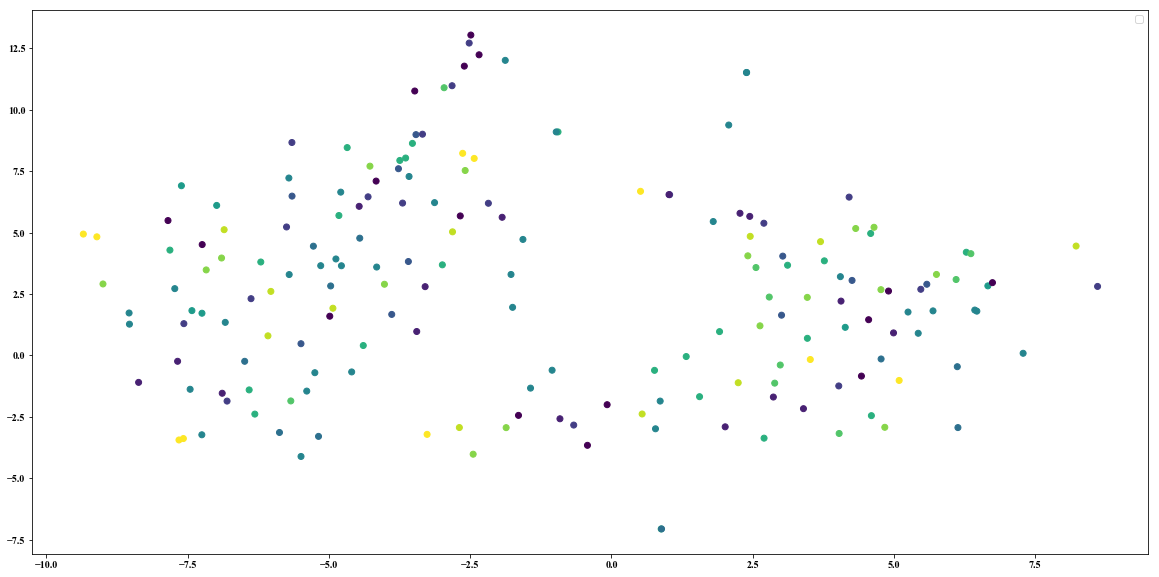

In [59]:
fig = plt.figure(figsize=(20, 10))
cmap = pd.DataFrame(pd.Series([i[0].split('-')[5] for i in tumor_samples_ctype.columns[1:].str.split('|')]).unique(), columns=['ID'])
cmap['number'] = np.arange(cmap.shape[0])
cmap.set_index('ID', inplace=True)
codes = pd.DataFrame([i[0].split('-')[5] for i in tumor_samples_ctype.columns.str.split('|')], columns=['ID'])
colors = codes.join(mapping, on='ID').number
plt.scatter(emb[:, 0], emb[:, 1], c=colors)

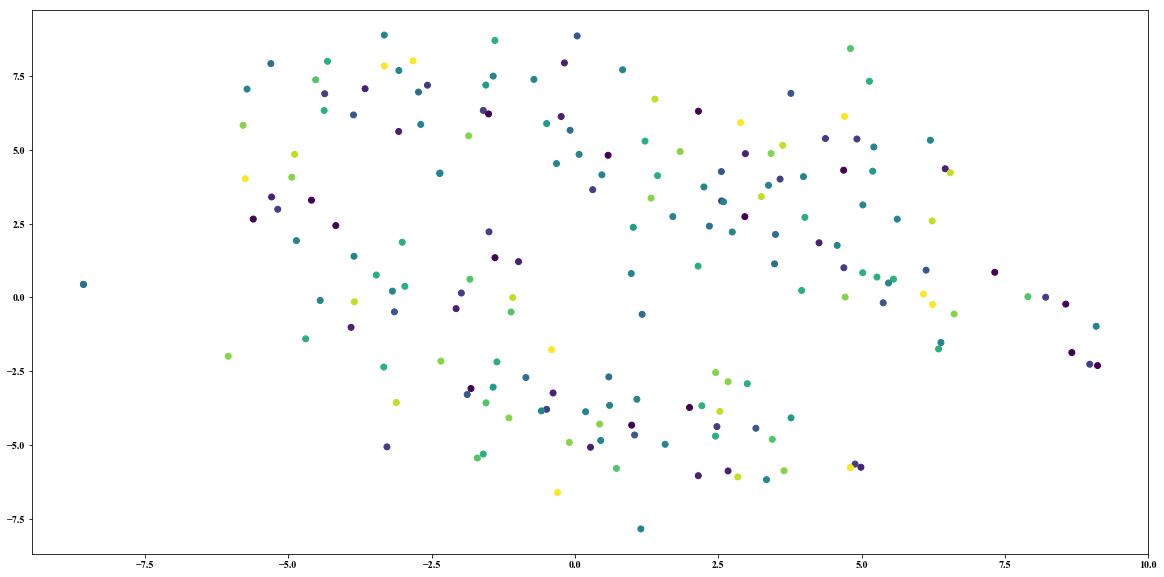

In [70]:
adjusted_tumor = pd.read_csv('../../data/pancancer/TCGA/methylation/gene_sample_matrices_cancertype/PAAD/tumor_samples.adjusted.tsv', sep='\t')
fig = plt.figure(figsize=(20, 10))
emb_new = TSNE(n_components=2).fit_transform(adjusted_tumor.T)
plt.scatter(emb_new[:, 0], emb_new[:, 1], c=colors)